## EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = 'RfqData2023.xlsx'


In [3]:
data_IS = pd.read_excel(data, sheet_name=pd.ExcelFile(data).sheet_names[0])
data_OOS= pd.read_excel(data, sheet_name=pd.ExcelFile(data).sheet_names[1])
data_NEW = pd.read_excel(data, sheet_name=pd.ExcelFile(data).sheet_names[2])

In [4]:
data_IS

Time    Bond   Side  Notional Counterparty  MidPrice  QuotedPrice  \
0     25000  Bond_2    Bid      1000       Ctpy_0    87.740       87.700   
1     25001  Bond_0    Bid     80000       Ctpy_2    99.195       99.195   
2     25002  Bond_0  Offer      1000       Ctpy_0    99.095       99.115   
3     25003  Bond_0  Offer   2630000       Ctpy_3    99.295       99.305   
4     25004  Bond_0  Offer      1000       Ctpy_2    99.435       99.445   
...     ...     ...    ...       ...          ...       ...          ...   
4995  29995  Bond_0  Offer     10000       Ctpy_1   102.985      103.025   
4996  29996  Bond_0  Offer      1000       Ctpy_1   103.025      103.135   
4997  29997  Bond_2    Bid      1000       Ctpy_1    68.300       68.200   
4998  29998  Bond_0  Offer      1000       Ctpy_0   103.175      103.275   
4999  29999  Bond_0    Bid      1000       Ctpy_1   103.275      103.225   

      Competitors  Traded  NextMidPrice      PL  
0               4    DONE        87.910     2.1  
1               4    DONE        99.095   -80.0  
2               2    DONE        99.295    -1.8  
3               3    DONE        99.435 -3419.0  
4               3    DONE        99.525    -0.8  
...           ...     ...           ...     ...  
4995            2    DONE       103.025     0.0  
4996            2  MISSED       103.035     0.0  
4997            4    DONE        68.250     0.5  
4998            2  MISSED       103.275     0.0  
4999            3  MISSED       103.245     0.0  

[5000 rows x 11 columns]

In [5]:
data_OOS

Time    Bond   Side  Notional Counterparty  MidPrice  QuotedPrice  \
0    30000  Bond_2  Offer      1000       Ctpy_1    67.700       67.790   
1    30001  Bond_0  Offer      1000       Ctpy_1   103.055      103.125   
2    30002  Bond_2    Bid      1000       Ctpy_1    68.040       67.900   
3    30003  Bond_0    Bid      1000       Ctpy_1   102.945      102.915   
4    30004  Bond_0    Bid      1000       Ctpy_0   102.895      102.865   
..     ...     ...    ...       ...          ...       ...          ...   
995  30995  Bond_1    Bid  10000000       Ctpy_0   130.341      130.321   
996  30996  Bond_1  Offer      1000       Ctpy_0   130.161      130.221   
997  30997  Bond_1  Offer      1000       Ctpy_0   130.161      130.271   
998  30998  Bond_0    Bid      1000       Ctpy_1    98.715       98.695   
999  30999  Bond_2    Bid  10000000       Ctpy_0    66.420       66.380   

     Competitors  Traded  NextMidPrice  PL  
0              4     NaN        67.740 NaN  
1              3     NaN       103.035 NaN  
2              1     NaN        68.340 NaN  
3              1     NaN       102.895 NaN  
4              2     NaN       103.095 NaN  
..           ...     ...           ...  ..  
995            2     NaN       130.161 NaN  
996            3     NaN       130.161 NaN  
997            4     NaN       130.051 NaN  
998            4     NaN        98.685 NaN  
999            4     NaN        66.040 NaN  

[1000 rows x 11 columns]

In [6]:
data_NEW.to_csv("new_RFQ.csv")

In [7]:
data_EDA = data_IS.copy()

data_EDA['NextMidPriceDiff'] = data_EDA['NextMidPrice'] - data_EDA['MidPrice']

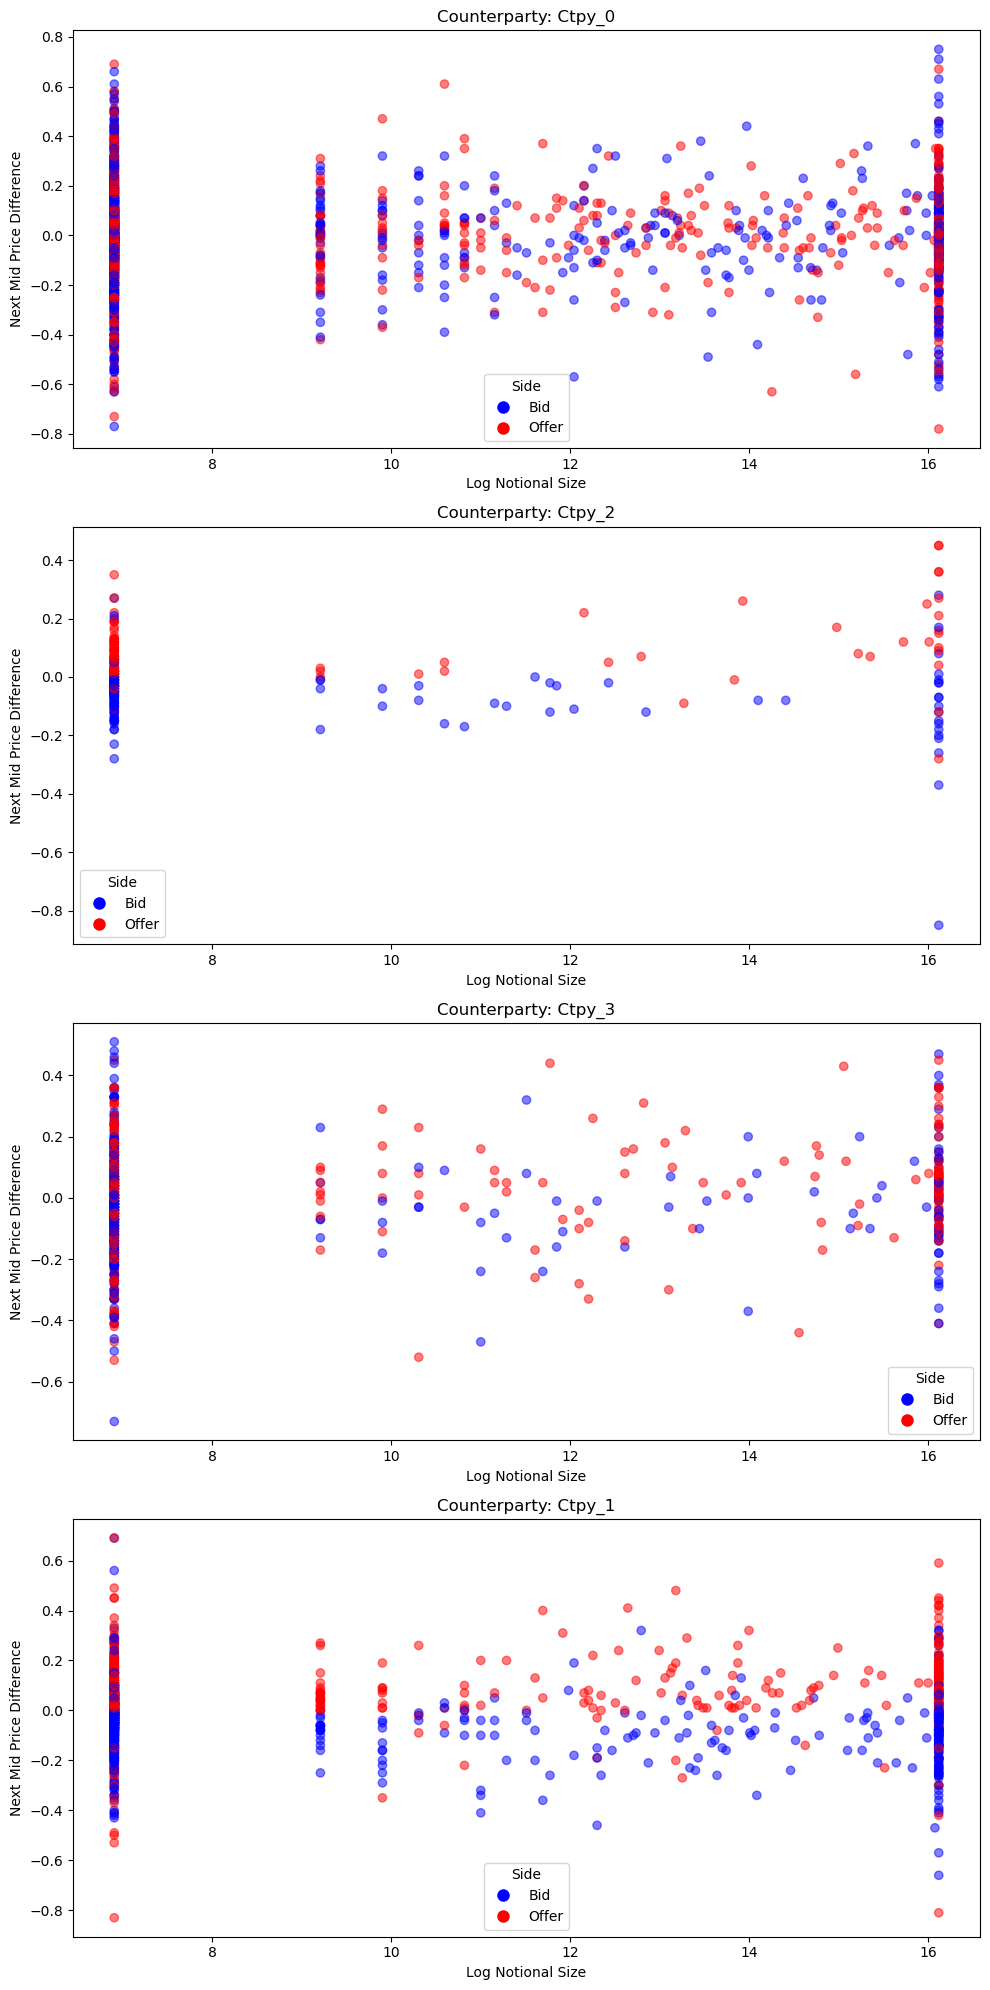

In [8]:
counterparties = data_EDA['Counterparty'].unique()

num_counterparties = len(counterparties)

color_map = {'Bid': 'blue', 'Offer': 'red'}

# Create subplots
fig, axes = plt.subplots(num_counterparties, 1, figsize=(10, num_counterparties * 5))

# If there's only one counterparty, we need to wrap axes in an array so that we can iterate over it
if num_counterparties == 1:
    axes = [axes]

for ax, counterparty in zip(axes, counterparties):
    ctpy_data = data_EDA[data_EDA['Counterparty'] == counterparty]
    # Scatter plot
    colors = ctpy_data['Side'].map(color_map)
    scatter = ax.scatter(np.log(ctpy_data['Notional']), ctpy_data['NextMidPriceDiff'], alpha=0.5, c=colors)
    
    legend_labels = {'Bid': 'blue', 'Offer': 'red'}
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=val, markersize=10) for key, val in legend_labels.items()]
    ax.legend(handles=handles, title='Side')

    ax.set_title(f'Counterparty: {counterparty}')
    ax.set_xlabel('Log Notional Size')
    ax.set_ylabel('Next Mid Price Difference')

plt.tight_layout()
plt.show()


Counterparty 1 and 2 seem more toxic/informed traders

## Model

In [9]:
# !git clone https://github.com/UBS-IB/adaptive-bayesian-reticulum

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier,MLPRegressor

import numpy as np
import datetime


from reticulum import AdaptiveBayesianReticulum

In [11]:
def fit_encoder(df):
    encoder = OneHotEncoder(drop='first')  # 使用 drop='first' 避免虚拟变量陷阱
    encoder.fit(df[['Bond', 'Counterparty']])
    return encoder

# 假设 data_IS 是您的训练集
encoder = fit_encoder(data_IS)

In [12]:
def process_data(df, encoder):
    df_processed = df.copy()
    df_processed['Spread'] = np.where(df_processed['Side'] == 'Bid', 
                                      (df_processed['MidPrice'] - df_processed['QuotedPrice']), 
                                      (df_processed['QuotedPrice'] - df_processed['MidPrice']))
    df_processed['Log Notional'] = np.log(df_processed['Notional'])

    # 使用训练集上定义的编码器来转换数据
    categorical_features = encoder.transform(df_processed[['Bond', 'Counterparty']]).toarray()
    categorical_feature_names = encoder.get_feature_names_out(['Bond', 'Counterparty'])

    encoded_df = pd.DataFrame(categorical_features, columns=categorical_feature_names)

    df_processed = df_processed.drop(['Bond', 'Counterparty', 'Side', 'Notional'], axis=1)
    df_processed = pd.concat([df_processed, encoded_df], axis=1)
    df_final = df_processed.drop(['Time', 'MidPrice', 'QuotedPrice', 'NextMidPrice', 'PL'], axis=1)

    return df_final


In [13]:
# def process_data(df):
#     df_processed = df.copy()
#     df_processed['Spread'] = np.where(df_processed['Side'] == 'Bid', 
#                                       (df_processed['MidPrice'] - df_processed['QuotedPrice']), 
#                                       (df_processed['QuotedPrice'] - df_processed['MidPrice']))
#     df_processed['Log Notional'] = np.log(df_processed['Notional'])
    
    
#     # One-hot encoding for categorical variables 'Bond' and 'Counterparty'
#     encoder = OneHotEncoder(drop='first')  # drop='first' to avoid the dummy variable trap
#     categorical_features = encoder.fit_transform(df_processed[['Bond', 'Counterparty']]).toarray()
#     categorical_feature_names = encoder.get_feature_names_out(['Bond', 'Counterparty'])

#     encoded_df = pd.DataFrame(categorical_features, columns=categorical_feature_names)

#     df_processed = df_processed.drop(['Bond', 'Counterparty', 'Side', 'Notional'], axis=1)  # drop the original categorical columns and 'Side'
#     df_processed = pd.concat([df_processed, encoded_df], axis=1)

    
#     df_final = df_processed.drop(['Time', 'MidPrice', 'QuotedPrice', 'NextMidPrice', 'PL'], axis=1)
    
    
#     return df_final

In [15]:
data_IS_processed = process_data(data_IS, encoder)
data_IS_processed

Competitors  Traded  Spread  Log Notional  Bond_Bond_1  Bond_Bond_2  \
0               4    DONE    0.04      6.907755          0.0          1.0   
1               4    DONE    0.00     11.289782          0.0          0.0   
2               2    DONE    0.02      6.907755          0.0          0.0   
3               3    DONE    0.01     14.782494          0.0          0.0   
4               3    DONE    0.01      6.907755          0.0          0.0   
...           ...     ...     ...           ...          ...          ...   
4995            2    DONE    0.04      9.210340          0.0          0.0   
4996            2  MISSED    0.11      6.907755          0.0          0.0   
4997            4    DONE    0.10      6.907755          0.0          1.0   
4998            2  MISSED    0.10      6.907755          0.0          0.0   
4999            3  MISSED    0.05      6.907755          0.0          0.0   

      Counterparty_Ctpy_1  Counterparty_Ctpy_2  Counterparty_Ctpy_3  
0                     0.0                  0.0                  0.0  
1                     0.0                  1.0                  0.0  
2                     0.0                  0.0                  0.0  
3                     0.0                  0.0                  1.0  
4                     0.0                  1.0                  0.0  
...                   ...                  ...                  ...  
4995                  1.0                  0.0                  0.0  
4996                  1.0                  0.0                  0.0  
4997                  1.0                  0.0                  0.0  
4998                  0.0                  0.0                  0.0  
4999                  1.0                  0.0                  0.0  

[5000 rows x 9 columns]

In [78]:
data_IS_processed['Spread'].hist()

<AxesSubplot:>

In [16]:
# Prepare the features (X) and the outcome variable (y)
data_IS_processed = process_data(data_IS, encoder)
X = data_IS_processed.drop(['Traded'], axis=1)
y = data_IS_processed['Traded']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [18]:
X_train[0]

array([-1.32791872,  0.04091382, -0.58283097, -0.32305144,  1.20394331,
       -0.64104192,  4.16516793, -0.4209074 ])

## Reticulum

In [19]:
# parameters need to be fine tuned
ABR = AdaptiveBayesianReticulum(
    prior=(1, 1),
    pruning_factor=1.01,
    n_iter=100,
    learning_rate_init=0.05,
    n_gradient_descent_steps=1,
    initial_relative_stiffness=42
)

ABR.fit(X_train, y_train, verbose=False)

accuracy_train = accuracy_score(y_train, ABR.predict(X_train))
accuracy_test = accuracy_score(y_test, ABR.predict(X_test))

# print(f'Depth:  {ABR.get_depth()}')
# print(f'Leaves: {ABR.get_n_leaves()}')
print(f'Train:  accuracy = {100*accuracy_train:.4f} %')
print(f'Test: accuracy = {100*accuracy_test:.4f} %')
print(f'Feature importance: {ABR.feature_importance()}')

Train:  accuracy = 82.5500 %
Test: accuracy = 84.5000 %
Feature importance: [0.12745817 0.29250489 0.14668073 0.09996756 0.06496958 0.0705691
 0.08515446 0.11269551]


## MLP

In [20]:
MLP = MLPClassifier(hidden_layer_sizes=(11,11,11), activation='logistic', solver='adam', max_iter=500)

MLP.fit(X_train, y_train)

y_pred = MLP.predict(X_test)

accuracy_train = accuracy_score(y_train, MLP.predict(X_train))
accuracy_test = accuracy_score(y_test, MLP.predict(X_test))

print(f'Train:  accuracy = {100*accuracy_train:.4f} %')
print(f'Test: accuracy = {100*accuracy_test:.4f} %')

# Evaluate the model
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


Train:  accuracy = 88.4500 %
Test: accuracy = 89.1000 %


In [21]:
print(report)

              precision    recall  f1-score   support

        DONE       0.89      0.90      0.90       527
      MISSED       0.89      0.88      0.88       473

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [22]:
conf_matrix

array([[474,  53],
       [ 56, 417]])

## Logistic Regression

In [23]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Train the model
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

accuracy_train = accuracy_score(y_train, logreg.predict(X_train))
accuracy_test = accuracy_score(y_test, logreg.predict(X_test))

print(f'Train:  accuracy = {100*accuracy_train:.4f} %')
print(f'Test: accuracy = {100*accuracy_test:.4f} %')

# Evaluate the model
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


Train:  accuracy = 85.5500 %
Test: accuracy = 86.0000 %


In [24]:
print(report)

              precision    recall  f1-score   support

        DONE       0.85      0.89      0.87       527
      MISSED       0.87      0.83      0.85       473

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



In [25]:
conf_matrix

array([[469,  58],
       [ 82, 391]])

## OOS Test

In [27]:
data_OOS_processed = process_data(data_OOS, encoder)
# data_OOS_processed

In [28]:
data_OOS

Time    Bond   Side  Notional Counterparty  MidPrice  QuotedPrice  \
0    30000  Bond_2  Offer      1000       Ctpy_1    67.700       67.790   
1    30001  Bond_0  Offer      1000       Ctpy_1   103.055      103.125   
2    30002  Bond_2    Bid      1000       Ctpy_1    68.040       67.900   
3    30003  Bond_0    Bid      1000       Ctpy_1   102.945      102.915   
4    30004  Bond_0    Bid      1000       Ctpy_0   102.895      102.865   
..     ...     ...    ...       ...          ...       ...          ...   
995  30995  Bond_1    Bid  10000000       Ctpy_0   130.341      130.321   
996  30996  Bond_1  Offer      1000       Ctpy_0   130.161      130.221   
997  30997  Bond_1  Offer      1000       Ctpy_0   130.161      130.271   
998  30998  Bond_0    Bid      1000       Ctpy_1    98.715       98.695   
999  30999  Bond_2    Bid  10000000       Ctpy_0    66.420       66.380   

     Competitors  Traded  NextMidPrice  PL  
0              4     NaN        67.740 NaN  
1              3     NaN       103.035 NaN  
2              1     NaN        68.340 NaN  
3              1     NaN       102.895 NaN  
4              2     NaN       103.095 NaN  
..           ...     ...           ...  ..  
995            2     NaN       130.161 NaN  
996            3     NaN       130.161 NaN  
997            4     NaN       130.051 NaN  
998            4     NaN        98.685 NaN  
999            4     NaN        66.040 NaN  

[1000 rows x 11 columns]

In [29]:
# incorrect_pl_rows = data_OOS[(data_OOS['Traded'] != 'DONE') & (data_OOS['PL'] != 0)]

# print(incorrect_pl_rows)


In [30]:
X_OOS = data_OOS_processed.drop(['Traded'], axis=1)
X_OOS = scaler.fit_transform(X_OOS)

### ABR

In [31]:
# Predict on the test set
data_OOS['Traded'] = ABR.predict(X_OOS)
data_OOS['HitRatio'] = ABR.predict_proba(X_OOS)[:, 0]
data_OOS

Time    Bond   Side  Notional Counterparty  MidPrice  QuotedPrice  \
0    30000  Bond_2  Offer      1000       Ctpy_1    67.700       67.790   
1    30001  Bond_0  Offer      1000       Ctpy_1   103.055      103.125   
2    30002  Bond_2    Bid      1000       Ctpy_1    68.040       67.900   
3    30003  Bond_0    Bid      1000       Ctpy_1   102.945      102.915   
4    30004  Bond_0    Bid      1000       Ctpy_0   102.895      102.865   
..     ...     ...    ...       ...          ...       ...          ...   
995  30995  Bond_1    Bid  10000000       Ctpy_0   130.341      130.321   
996  30996  Bond_1  Offer      1000       Ctpy_0   130.161      130.221   
997  30997  Bond_1  Offer      1000       Ctpy_0   130.161      130.271   
998  30998  Bond_0    Bid      1000       Ctpy_1    98.715       98.695   
999  30999  Bond_2    Bid  10000000       Ctpy_0    66.420       66.380   

     Competitors  Traded  NextMidPrice  PL  HitRatio  
0              4    DONE        67.740 NaN  0.506523  
1              3  MISSED       103.035 NaN  0.091389  
2              1  MISSED        68.340 NaN  0.262376  
3              1    DONE       102.895 NaN  0.728149  
4              2    DONE       103.095 NaN  0.848554  
..           ...     ...           ...  ..       ...  
995            2    DONE       130.161 NaN  0.945135  
996            3    DONE       130.161 NaN  0.517336  
997            4  MISSED       130.051 NaN  0.166729  
998            4    DONE        98.685 NaN  0.947330  
999            4    DONE        66.040 NaN  0.719290  

[1000 rows x 12 columns]

### Logistic Regression

In [32]:
data_OOS['Traded'] = logreg.predict(X_OOS)
data_OOS['HitRatio'] = logreg.predict_proba(X_OOS)[:, 0]
data_OOS

Time    Bond   Side  Notional Counterparty  MidPrice  QuotedPrice  \
0    30000  Bond_2  Offer      1000       Ctpy_1    67.700       67.790   
1    30001  Bond_0  Offer      1000       Ctpy_1   103.055      103.125   
2    30002  Bond_2    Bid      1000       Ctpy_1    68.040       67.900   
3    30003  Bond_0    Bid      1000       Ctpy_1   102.945      102.915   
4    30004  Bond_0    Bid      1000       Ctpy_0   102.895      102.865   
..     ...     ...    ...       ...          ...       ...          ...   
995  30995  Bond_1    Bid  10000000       Ctpy_0   130.341      130.321   
996  30996  Bond_1  Offer      1000       Ctpy_0   130.161      130.221   
997  30997  Bond_1  Offer      1000       Ctpy_0   130.161      130.271   
998  30998  Bond_0    Bid      1000       Ctpy_1    98.715       98.695   
999  30999  Bond_2    Bid  10000000       Ctpy_0    66.420       66.380   

     Competitors  Traded  NextMidPrice  PL  HitRatio  
0              4    DONE        67.740 NaN  0.808416  
1              3  MISSED       103.035 NaN  0.489912  
2              1  MISSED        68.340 NaN  0.029464  
3              1    DONE       102.895 NaN  0.632064  
4              2    DONE       103.095 NaN  0.651597  
..           ...     ...           ...  ..       ...  
995            2    DONE       130.161 NaN  0.885629  
996            3    DONE       130.161 NaN  0.566107  
997            4  MISSED       130.051 NaN  0.166818  
998            4    DONE        98.685 NaN  0.966561  
999            4    DONE        66.040 NaN  0.978824  

[1000 rows x 12 columns]

### MLP

In [33]:
data_OOS['Traded'] = MLP.predict(X_OOS)
data_OOS['HitRatio'] = MLP.predict_proba(X_OOS)[:, 0]
data_OOS

Time    Bond   Side  Notional Counterparty  MidPrice  QuotedPrice  \
0    30000  Bond_2  Offer      1000       Ctpy_1    67.700       67.790   
1    30001  Bond_0  Offer      1000       Ctpy_1   103.055      103.125   
2    30002  Bond_2    Bid      1000       Ctpy_1    68.040       67.900   
3    30003  Bond_0    Bid      1000       Ctpy_1   102.945      102.915   
4    30004  Bond_0    Bid      1000       Ctpy_0   102.895      102.865   
..     ...     ...    ...       ...          ...       ...          ...   
995  30995  Bond_1    Bid  10000000       Ctpy_0   130.341      130.321   
996  30996  Bond_1  Offer      1000       Ctpy_0   130.161      130.221   
997  30997  Bond_1  Offer      1000       Ctpy_0   130.161      130.271   
998  30998  Bond_0    Bid      1000       Ctpy_1    98.715       98.695   
999  30999  Bond_2    Bid  10000000       Ctpy_0    66.420       66.380   

     Competitors  Traded  NextMidPrice  PL  HitRatio  
0              4    DONE        67.740 NaN  0.832521  
1              3  MISSED       103.035 NaN  0.161337  
2              1  MISSED        68.340 NaN  0.036118  
3              1    DONE       102.895 NaN  0.665522  
4              2    DONE       103.095 NaN  0.851762  
..           ...     ...           ...  ..       ...  
995            2    DONE       130.161 NaN  0.994550  
996            3  MISSED       130.161 NaN  0.497001  
997            4  MISSED       130.051 NaN  0.026302  
998            4    DONE        98.685 NaN  0.992941  
999            4    DONE        66.040 NaN  0.966681  

[1000 rows x 12 columns]

In [34]:
def calc_PL(row):
    if row['Traded'] != 'DONE':
        return 0
    else:
        if row['Side'] == 'Bid':
            return (row['NextMidPrice'] - row['QuotedPrice'])* row['Notional']
        else:
            return (row['QuotedPrice'] - row['NextMidPrice'])* row['Notional']

In [35]:
data_OOS['PL'] = data_OOS.apply(calc_PL, axis=1)

In [36]:
data_OOS[data_OOS['HitRatio']<=0.5]['PL'].sum()

0.0

In [37]:
# data_OOS.to_csv('RFQ_OOS.csv')

In [38]:
def calc_total_PL(df, threshold):
    total_PL = df[df['HitRatio'] <= threshold]['PL'].sum()
    return total_PL

In [39]:
unique_bonds = data_OOS['Bond'].unique()
unique_counterparties = data_OOS['Counterparty'].unique()
combinations = [(bond, ctpy) for bond in unique_bonds for ctpy in unique_counterparties]
combinations

[('Bond_2', 'Ctpy_1'),
 ('Bond_2', 'Ctpy_0'),
 ('Bond_2', 'Ctpy_3'),
 ('Bond_2', 'Ctpy_2'),
 ('Bond_0', 'Ctpy_1'),
 ('Bond_0', 'Ctpy_0'),
 ('Bond_0', 'Ctpy_3'),
 ('Bond_0', 'Ctpy_2'),
 ('Bond_1', 'Ctpy_1'),
 ('Bond_1', 'Ctpy_0'),
 ('Bond_1', 'Ctpy_3'),
 ('Bond_1', 'Ctpy_2')]

In [40]:
data_OOS

Time    Bond   Side  Notional Counterparty  MidPrice  QuotedPrice  \
0    30000  Bond_2  Offer      1000       Ctpy_1    67.700       67.790   
1    30001  Bond_0  Offer      1000       Ctpy_1   103.055      103.125   
2    30002  Bond_2    Bid      1000       Ctpy_1    68.040       67.900   
3    30003  Bond_0    Bid      1000       Ctpy_1   102.945      102.915   
4    30004  Bond_0    Bid      1000       Ctpy_0   102.895      102.865   
..     ...     ...    ...       ...          ...       ...          ...   
995  30995  Bond_1    Bid  10000000       Ctpy_0   130.341      130.321   
996  30996  Bond_1  Offer      1000       Ctpy_0   130.161      130.221   
997  30997  Bond_1  Offer      1000       Ctpy_0   130.161      130.271   
998  30998  Bond_0    Bid      1000       Ctpy_1    98.715       98.695   
999  30999  Bond_2    Bid  10000000       Ctpy_0    66.420       66.380   

     Competitors  Traded  NextMidPrice         PL  HitRatio  
0              4    DONE        67.740       50.0  0.832521  
1              3  MISSED       103.035        0.0  0.161337  
2              1  MISSED        68.340        0.0  0.036118  
3              1    DONE       102.895      -20.0  0.665522  
4              2    DONE       103.095      230.0  0.851762  
..           ...     ...           ...        ...       ...  
995            2    DONE       130.161 -1600000.0  0.994550  
996            3  MISSED       130.161        0.0  0.497001  
997            4  MISSED       130.051        0.0  0.026302  
998            4    DONE        98.685      -10.0  0.992941  
999            4    DONE        66.040 -3400000.0  0.966681  

[1000 rows x 12 columns]

### Ctpy

Ctpy_1
0.52


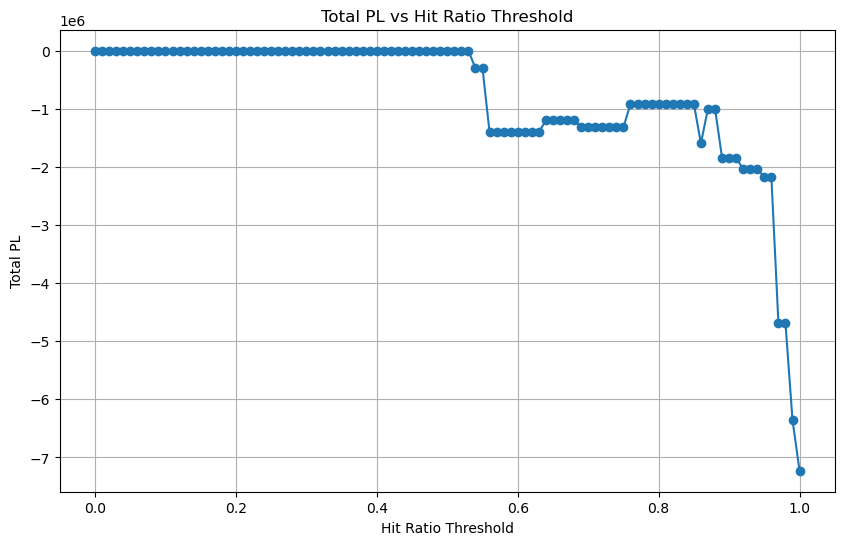

Ctpy_0
0.9400000000000001


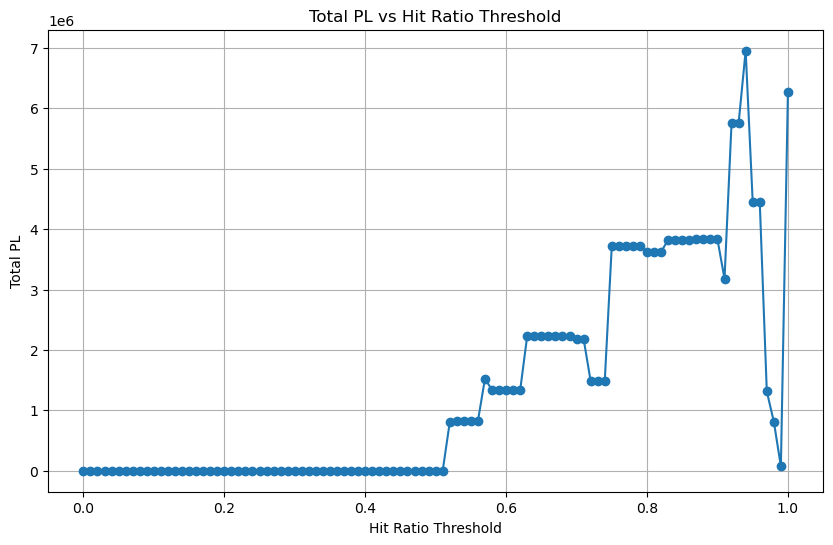

Ctpy_3
0.98


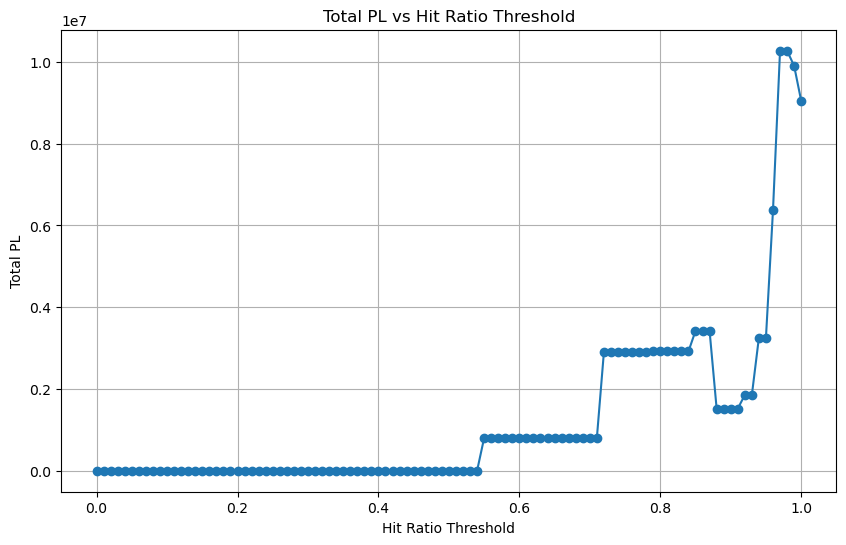

Ctpy_2
0.0


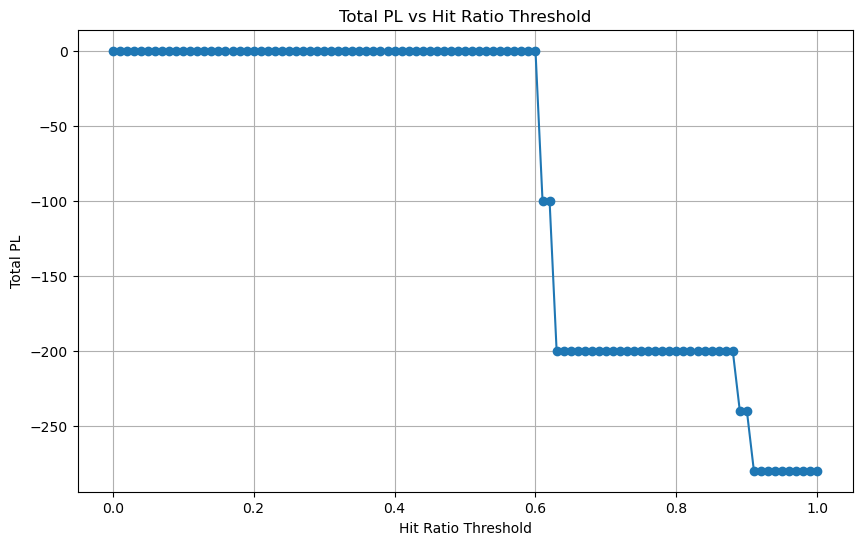

In [41]:
for cpty in data_OOS['Counterparty'].unique().tolist():
    print(cpty)
    sub_df = data_OOS[(data_OOS['Counterparty']==cpty)]
    total_PLs = []
    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        total_PLs.append(calc_total_PL(sub_df, threshold))

    max_PL = max(total_PLs)
    opt_threshold = thresholds[total_PLs.index(max_PL)]
    print(opt_threshold)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, total_PLs, marker='o')
    plt.xlabel('Hit Ratio Threshold')
    plt.ylabel('Total PL')
    plt.title('Total PL vs Hit Ratio Threshold')
    plt.grid(True)
    plt.show()

### Combination of Bond and Cpty

('Bond_2', 'Ctpy_1')
0.52


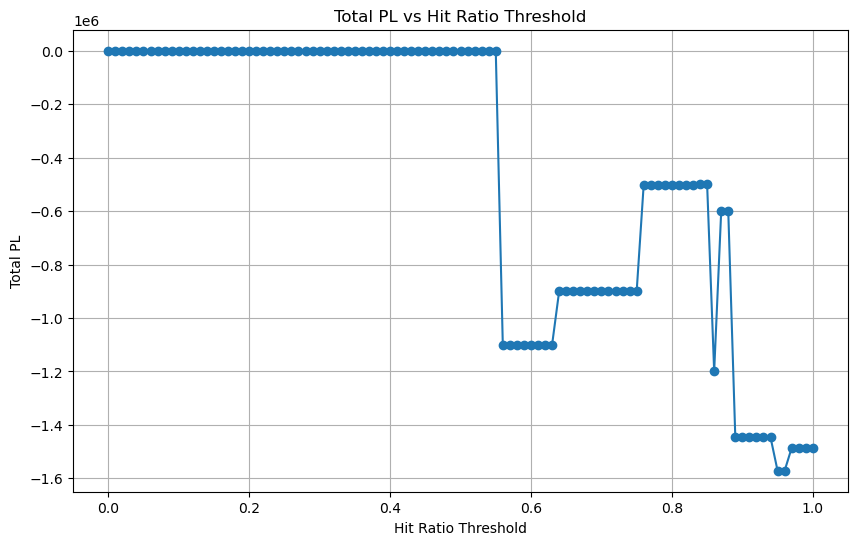

('Bond_2', 'Ctpy_0')
0.9400000000000001


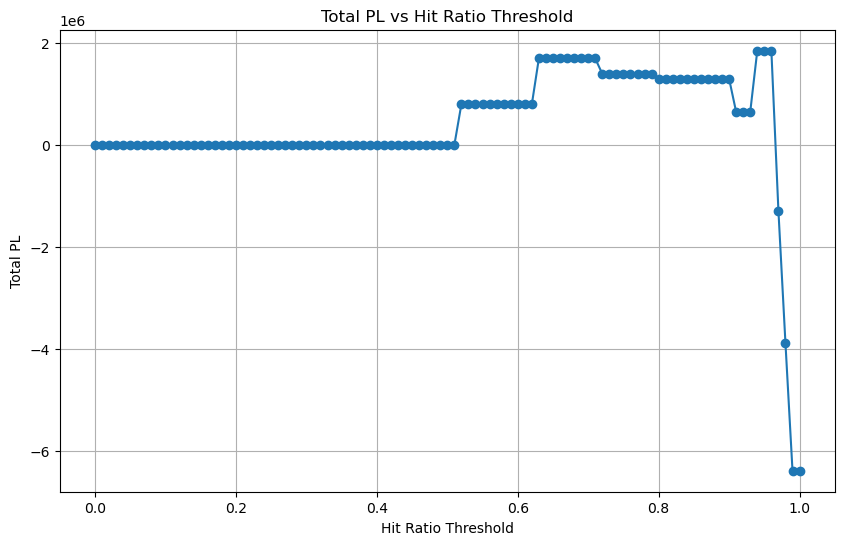

('Bond_2', 'Ctpy_3')
1.0


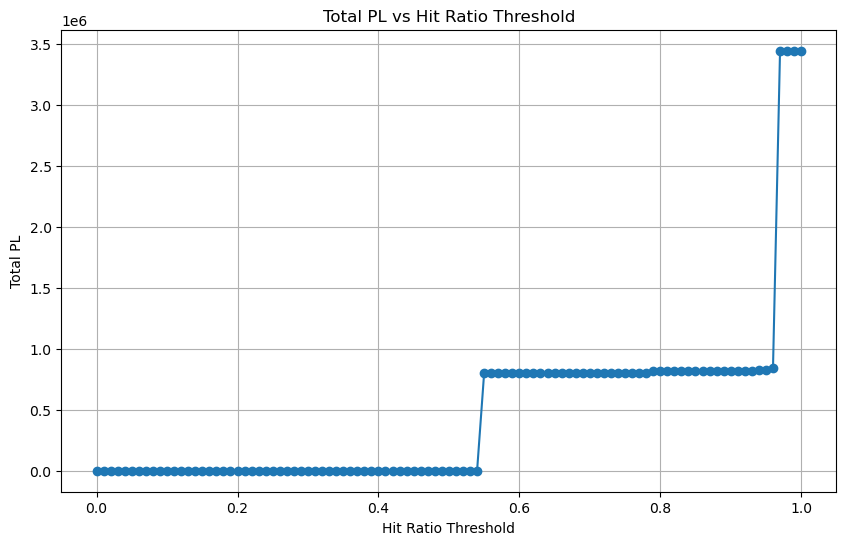

('Bond_2', 'Ctpy_2')
0.0


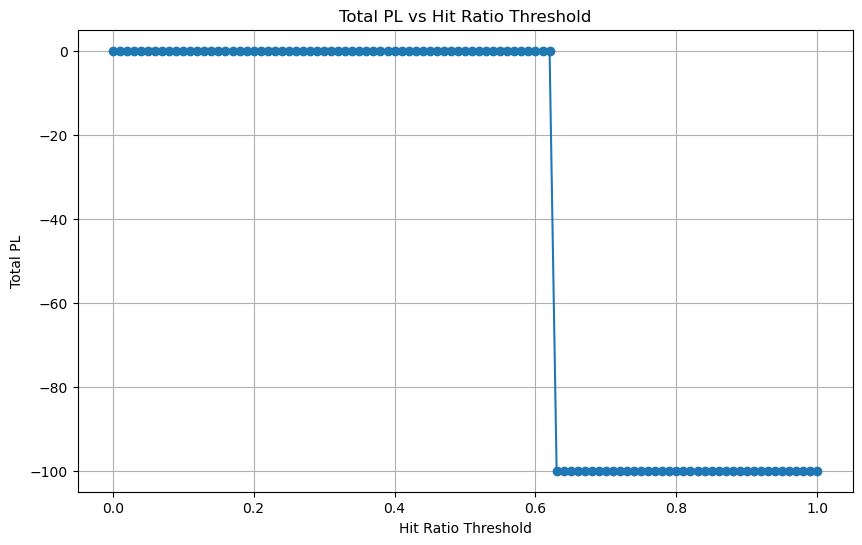

('Bond_0', 'Ctpy_1')
0.0


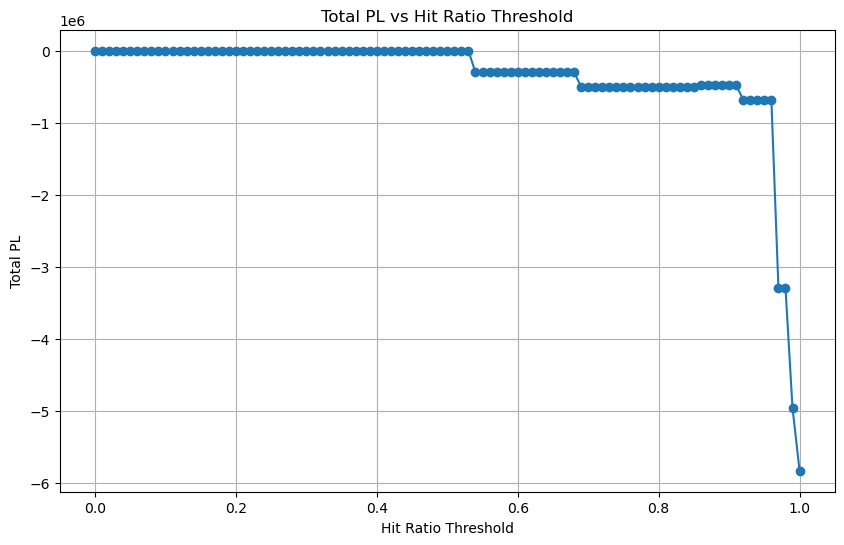

('Bond_0', 'Ctpy_0')
1.0


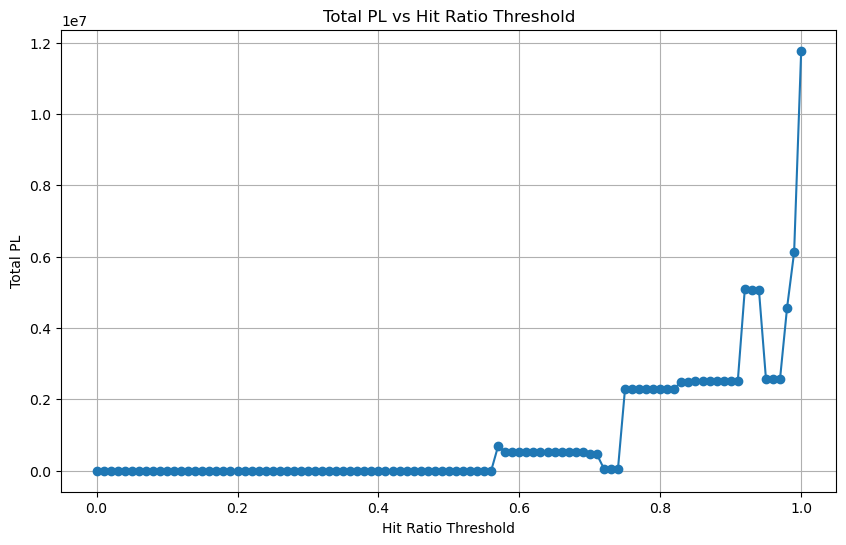

('Bond_0', 'Ctpy_3')
0.97


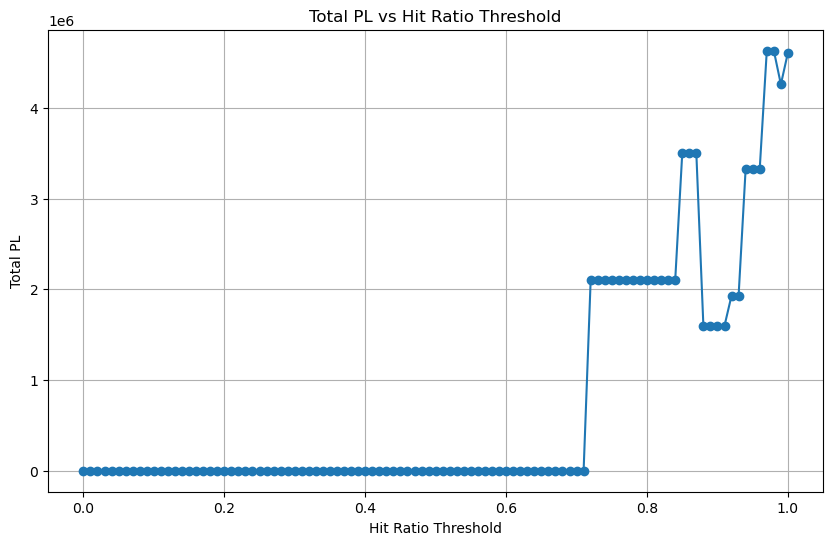

('Bond_0', 'Ctpy_2')
0.0


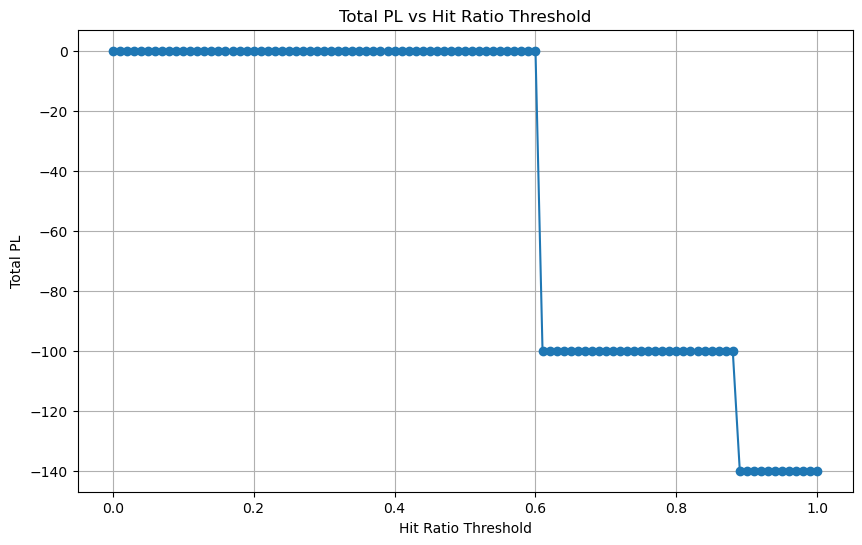

('Bond_1', 'Ctpy_1')
0.99


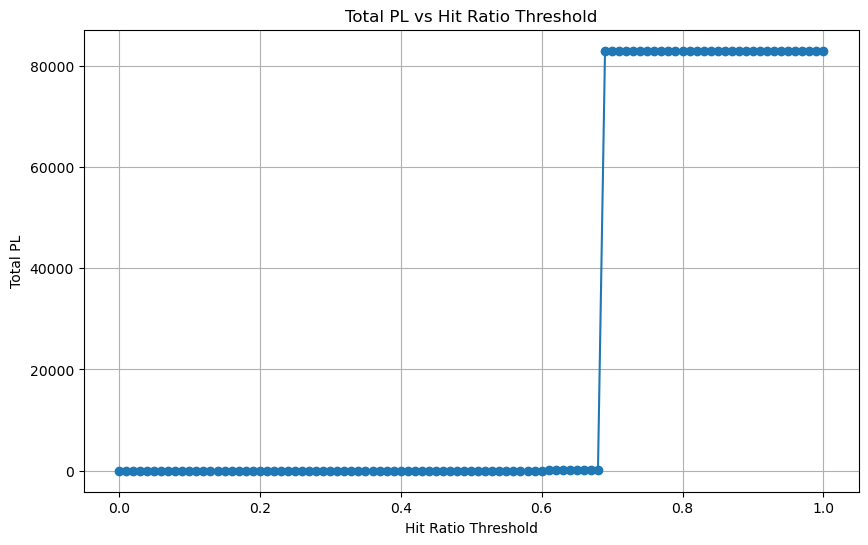

('Bond_1', 'Ctpy_0')
1.0


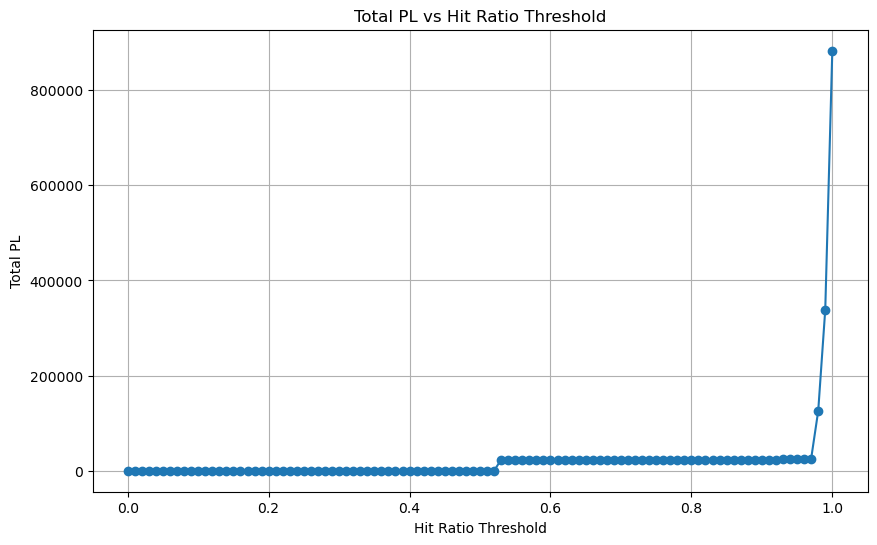

('Bond_1', 'Ctpy_3')
0.96


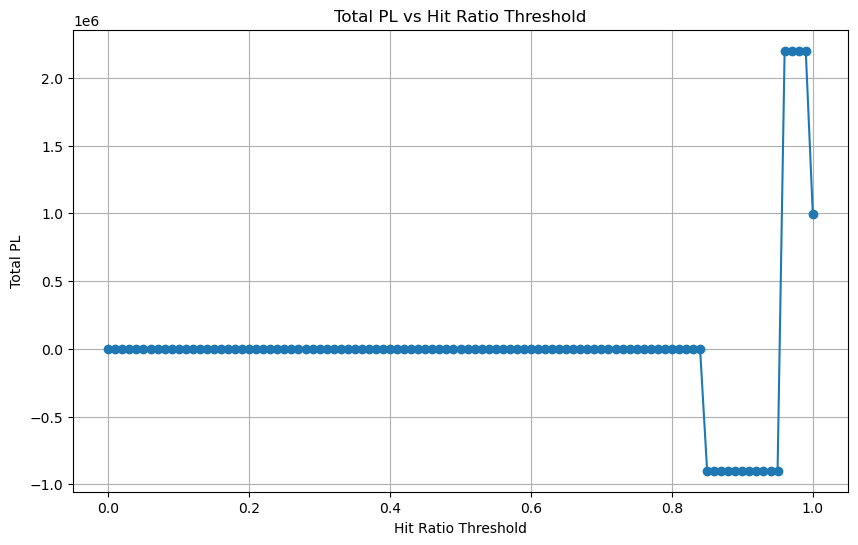

('Bond_1', 'Ctpy_2')
0.0


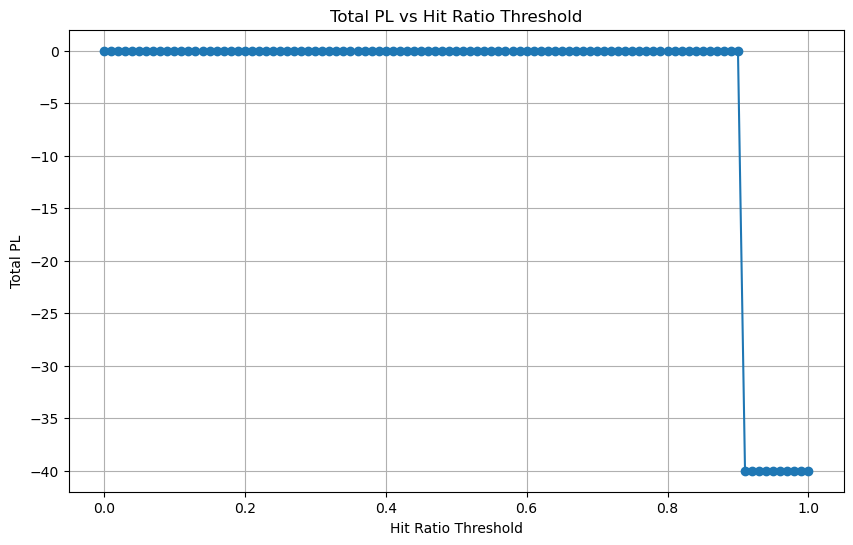

In [42]:
for comb in combinations:
    print(comb)
    sub_df = data_OOS[(data_OOS['Bond']==comb[0]) & (data_OOS['Counterparty']==comb[1])]
    total_PLs = []
    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        total_PLs.append(calc_total_PL(sub_df, threshold))

    max_PL = max(total_PLs)
    opt_threshold = thresholds[total_PLs.index(max_PL)]
    print(opt_threshold)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, total_PLs, marker='o')
    plt.xlabel('Hit Ratio Threshold')
    plt.ylabel('Total PL')
    plt.title('Total PL vs Hit Ratio Threshold')
    plt.grid(True)
    plt.show()

## Competition

In [43]:
data_NEW_processed = process_data(data_NEW, encoder)

In [44]:
data_NEW_processed

Competitors  Traded  Spread  Log Notional  Bond_Bond_1  Bond_Bond_2  \
0            1     NaN     NaN     11.002100          0.0          0.0   
1            3     NaN     NaN      6.907755          0.0          1.0   
2            1     NaN     NaN      6.907755          0.0          0.0   
3            4     NaN     NaN     12.429216          0.0          1.0   
4            4     NaN     NaN      6.907755          0.0          0.0   
5            3     NaN     NaN     16.118096          1.0          0.0   
6            3     NaN     NaN      9.903488          0.0          1.0   
7            4     NaN     NaN      6.907755          0.0          0.0   
8            4     NaN     NaN      6.907755          0.0          1.0   
9            3     NaN     NaN      6.907755          0.0          0.0   

   Counterparty_Ctpy_1  Counterparty_Ctpy_2  Counterparty_Ctpy_3  
0                  0.0                  0.0                  0.0  
1                  0.0                  0.0                  1.0  
2                  0.0                  0.0                  0.0  
3                  0.0                  0.0                  0.0  
4                  1.0                  0.0                  0.0  
5                  0.0                  0.0                  0.0  
6                  1.0                  0.0                  0.0  
7                  0.0                  0.0                  1.0  
8                  1.0                  0.0                  0.0  
9                  0.0                  0.0                  0.0

In [81]:
probs = []
spreads = np.arange(0,1.0,0.01)
selected_row = data_NEW.iloc[5]
replicated_data = pd.DataFrame([selected_row] * len(spreads), index=range(len(spreads)))
replicated_data_processed = process_data(replicated_data, encoder)
replicated_data_processed['Spread'] = spreads
replicated_data_processed
X = replicated_data_processed.drop(['Traded'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
probs = MLP.predict_proba(X)[:,0]

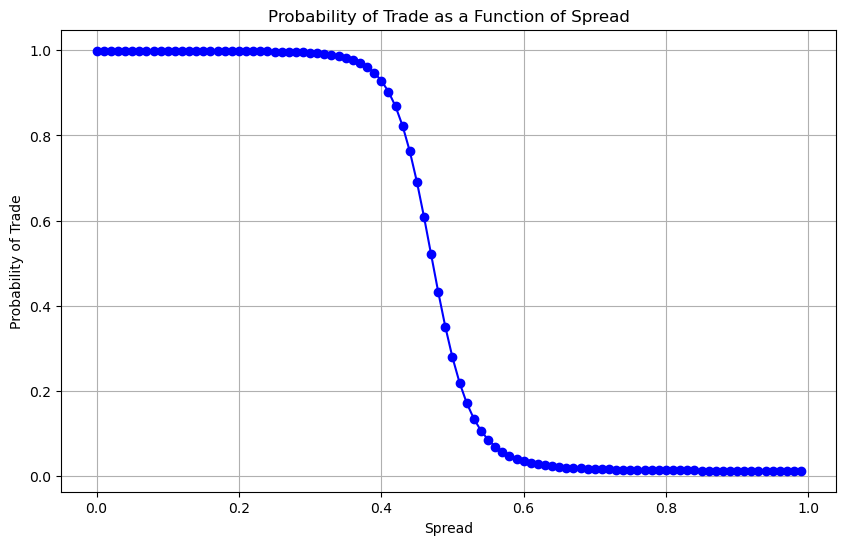

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(spreads, probs, '-o', color='blue')
plt.title('Probability of Trade as a Function of Spread')
plt.xlabel('Spread')
plt.ylabel('Probability of Trade')
plt.grid(True)
plt.show()
